In [112]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process import kernels
from scipy.stats import norm
from scipy.optimize import minimize
import sys
import pandas as pd

import io
from contextlib import redirect_stdout

import sys
sys.path.append('../pyJive/')
from utils import proputils as pu
import main
from names import GlobNames as gn
%matplotlib widget

In [130]:
def get_geom_file(y_list): 
    
    file = open('bridge.geom')
    filestring = file.read()

    split = filestring.split('\n')

    y_list = np.append(y_list, y_list[:-1][::-1])
    mod_indices = np.arange(3,20,2)

    count = 0
    for i in range(len(split)):
        split[i] += '\n'
        if i in mod_indices:
            linesplit = split[i].split(' ')
            linesplit[-1] = str(y_list[count]) + '\n'
            split[i] = ' '.join(linesplit)
            count += 1

    geom = ' '.join(split)

    with open("geomfile.geom", "w") as file:
        file.write(geom)
        
    return file.name

def eigenfrequencies(A_list, y_list):

    # Read the input file and store in props object
    props = pu.parse_file('bridge_frequency copy.pro')
    props['model']['truss']['area'] = A_list
    props['init']['mesh']['file'] = get_geom_file(y_list)
    
    
    # Call the program and store output in globdat
    trap = io.StringIO()
    with redirect_stdout(trap):
        globdat = main.jive(props)
    
    # Write additional output
    return(globdat[gn.EIGENFREQS][0:3]/2/np.pi)

def eigenfrequencies_1(A_list, y_list):

    # Read the input file and store in props object
    props = pu.parse_file('bridge_frequency.pro')
    props['model']['truss']['area'] = A_list
    props['init']['mesh']['file'] = get_geom_file(y_list)
    
    
    # Call the program and store output in globdat
    trap = io.StringIO()
    with redirect_stdout(trap):
        globdat = main.jive(props)
    
    # Write additional output
    return(globdat[gn.EIGENFREQS][0:3]/2/np.pi)

def constraint(A_list, y_list, constr1=20, constr2=40, constr3=60):
    # convert first three natrual frequencies to Hz
    freq1, freq2, freq3 = eigenfrequencies(A_list, y_list)

    # calculate the violations of the constraints
    violation1 = max(0, constr1 - freq1)
    violation2 = max(0, constr2 - freq2)
    violation3 = max(0, constr3 - freq3)

    imag_parts = np.abs(np.sum(np.imag([freq1, freq2, freq3])))
    
    #calculate the losses with the penalty
    total_violation = violation1 + violation2 + violation3 + imag_parts
    if total_violation > 0:
        total_violation += 0
    return total_violation

def mass_TRUSS(Areas, y_list, density=7800):
    
    x_coordinates=[0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10]
    y_coordinates = [0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
    y_coordinates[2] = y_list[0]
    y_coordinates[4] = y_list[1]
    y_coordinates[6] = y_list[2]
    y_coordinates[8] = y_list[3]
    y_coordinates[10] = y_list[4]
    y_coordinates[12] = y_list[3]
    y_coordinates[14] = y_list[2]
    y_coordinates[16] = y_list[1]
    y_coordinates[18] = y_list[0]
    
    #Calculate the lengths of the different elements
    Lengths = np.zeros(len(Areas))
    Lengths[0] = 1
    Lengths[1] = np.sqrt(x_coordinates[2]**2 + y_coordinates[2]**2)
    Lengths[2] = y_coordinates[2]
    Lengths[3] = np.sqrt((x_coordinates[2]-x_coordinates[3])**2 + (y_coordinates[2]-y_coordinates[3])**2)
    Lengths[4] = np.sqrt(1 + (y_coordinates[2]-y_coordinates[4])**2)
    Lengths[5] = y_coordinates[4]
    Lengths[6] = np.sqrt((x_coordinates[4]-x_coordinates[5])**2 + (y_coordinates[4]-y_coordinates[5])**2)
    Lengths[7] = np.sqrt(1 + (y_coordinates[4]-y_coordinates[6])**2)
    Lengths[8] = y_coordinates[6]
    Lengths[9] = np.sqrt((x_coordinates[6]-x_coordinates[7])**2 + (y_coordinates[6]-y_coordinates[7])**2)
    Lengths[10] = np.sqrt(1 + (y_coordinates[6]-y_coordinates[8])**2)
    Lengths[11] = y_coordinates[8]
    Lengths[12] = np.sqrt((x_coordinates[8]-x_coordinates[9])**2 + (y_coordinates[8]-y_coordinates[9])**2)
    Lengths[13] = np.sqrt(1 + (y_coordinates[8]-y_coordinates[10])**2)
    Lengths[14] = y_coordinates[10]
    
    #Calculate the volumes of the elements
    Volumes = Lengths * Areas
    
    #Calculate the total volume by summing the elements
    Total_Volume = 10*Volumes[0] + 2*(Volumes[1] + Volumes[2] + Volumes[3] + Volumes[4] + Volumes[5] + Volumes[6] + Volumes[7] + Volumes[9] + Volumes[10] + Volumes[11] + Volumes[12] + Volumes[13]) + Volumes[14]
    
    #Calculate the total mass
    Mass = Total_Volume * density
    
    return Mass


def loss_function(x_list, mass_penalty=1, constraint_penalty=1000, Area_lower=4e-3):
    A_list = x_list[5:]
    A_list = np.append([Area_lower], A_list)
    y_list = x_list[0:5]
    mass = mass_TRUSS(A_list, y_list)
    total_loss = np.abs((constraint_penalty * constraint(A_list, y_list)) + (mass_penalty * mass))
    if (mass <= 0):
        total_loss += constraint_penalty * mass
    #if constraint(A_list, y_list) != 0:
    #   print(f'The constraints for the natural frequencies are not met')
    #else:
    #   print(f'The constraints of the natural frequencies are met')
    #print(f'The total loss is:{total_loss}')
        
    return total_loss


def final_results(x_list, Area_lower=4e-3):
    A_list = x_list[5:]
    A_list = np.append([Area_lower], A_list)
    y_list = x_list[0:5]

    if constraint(A_list, y_list) != 0:
        print(f'The constraints for the natural frequencies are not met')
    else:
        print(f'The constraints of the natural frequencies are met')
        
    return mass_TRUSS(A_list, y_list), eigenfrequencies(A_list, y_list)

def costly_function(x):
    total = np.array([])
    for x_i in x:
        total = np.append(total, np.sum(np.exp(-(x_i - 5) ** 2)))
    
    return total + np.random.randn()

In [131]:
class BayesianOptimizer():
      
    def __init__(self, target_func, x_init, y_init, n_iter, batch_size):
        self.x_init = x_init
        self.y_init = y_init
        self.target_func = target_func
        self.n_iter = n_iter
        self.batch_size = batch_size
        self.gauss_pr = GaussianProcessRegressor(kernel=kernels.RBF())
        self.best_samples_ = pd.DataFrame(columns = ['x', 'y', 'ei'])
        self.distances_ = []


    def _get_expected_improvement(self, x_new):

        # Using estimate from Gaussian surrogate instead of actual function for 
        # a new trial data point to avoid cost

        use_x = x_new.copy()
        use_x[5:] *= 10**3

        mean_y_new, sigma_y_new = self.gauss_pr.predict(np.array(use_x).reshape(1, -1), return_std=True)
        #sigma_y_new = sigma_y_new.reshape(-1,1)
        if sigma_y_new[0] == 0.0:
            return 0.0
        
        # Using estimates from Gaussian surrogate instead of actual function for 
        # entire prior distribution to avoid cost
        
        min_mean_y = self.y_min#mean_y#np.min(mean_y)
        z = (min_mean_y - mean_y_new) / sigma_y_new
        exp_imp = (min_mean_y - mean_y_new) / min_mean_y * norm.cdf(z) + sigma_y_new
        expr = 0
        if expr != 0:
            print(expr)
        return exp_imp
    

    def _acquisition_function(self, x):
        return -self._get_expected_improvement(x)
        
        
    def _get_next_probable_point(self, bounds=None):
        min_ei = float(sys.maxsize)
        x_optimal = None 
                
        # Trial with an array of random data points
        #mean_y = np.min(self.gauss_pr.predict(self.x_init))
        for b in range(self.batch_size):
            x_start = Next_guess()
            bnds = ((0.00001, 2), (0.00001, 2), (0.00001, 2), (0.00001, 2), (0.00001, 2), (0.0001, 0.002), (0.0001, 0.002), (0.0001, 0.002), (0.0001, 0.002), (0.0001, 0.002), (0.0001, 0.002), (0.0001, 0.002), (0.0001, 0.002), (0.0001, 0.002), (0.0001, 0.002), (0.0001, 0.002), (0.0001, 0.002), (0.0001, 0.002), (0.0001, 0.002))
        
            response = minimize(fun=self._acquisition_function, x0=x_start, bounds=bnds, method='L-BFGS-B')
            # if response.fun[0] < min_ei:

            if response.fun < min_ei:
            #    # min_ei = response.fun[0]
                min_ei = response.fun
                x_optimal = response.x
            
            ei = self._acquisition_function(x_start)
            if ((ei < min_ei) & (np.abs(ei) < self.y_min)):
                min_ei = ei
                x_optimal = x_start
        
        #bnds = ((0.00001, 2), (0.00001, 2), (0.00001, 2), (0.00001, 2), (0.00001, 2), (0.0001, 0.01), (0.0001, 0.01), (0.0001, 0.01), (0.0001, 0.01), (0.0001, 0.01), (0.0001, 0.01), (0.0001, 0.01), (0.0001, 0.01), (0.0001, 0.01), (0.0001, 0.01), (0.0001, 0.01), (0.0001, 0.01), (0.0001, 0.01), (0.0001, 0.01))
        #response = minimize(self._acquisition_function, x_optimal, bounds=bnds)
        #if response.fun < min_ei:
        #    # min_ei = response.fun[0]
        #min_ei = response.fun
        #x_optimal = response.x
        print(min_ei)
        return x_optimal, min_ei
    
    
    def _extend_prior_with_posterior_data(self, x,y):
        self.x_init = np.append(self.x_init, np.array([x]), axis = 0)
        self.y_init = np.append(self.y_init, np.array([y]), axis = 0)
  

    def optimize(self):
        y_min_ind = np.argmin(self.y_init)
        y_min = self.y_min = self.y_init[y_min_ind]
        optimal_x = self.x_init[y_min_ind]
        optimal_ei = None
        best_iter = 0

        for i in range(self.n_iter):
            print(f'Iteration: {i}, the best loss = {y_min:.2f}')
            use_x = self.x_init.copy()
            use_x[:, 5:] *= 10**3
            self.gauss_pr.fit(use_x, self.y_init)
            x_next, ei = self._get_next_probable_point()
            y_next = self.target_func(np.array(x_next))
            print(y_next)
            self._extend_prior_with_posterior_data(x_next,y_next)

            if ((y_next < y_min) & (y_next > 0)):
                y_min = y_next
                self.y_min = y_next
                optimal_x = self.optimal_x = x_next
                # optimal_ei = ei[0]
                optimal_ei = ei
                best_iter = i

            if i == 0:
                prev_x = x_next
            else:
                self.distances_.append(np.linalg.norm(prev_x - x_next))
                prev_x = x_next
                
            self.best_samples_ = pd.concat((self.best_samples_, pd.DataFrame({"y": [y_min], "ei": [optimal_ei]})), ignore_index=True)
        return optimal_x, y_min
            

In [137]:
def Initial_guess():
    y = np.random.uniform(0, 2, 5)
    Areas = np.random.uniform(0.00001, 0.001, 14)

    x_list = np.append(y, Areas)
    return x_list

def Next_guess(y_bound=(0.00001, 2), A_bound=(0.00001, 0.001)):
    y = np.random.uniform(y_bound[0], y_bound[1], 5)
    Areas = np.random.uniform(A_bound[0], A_bound[1], 14)
    x_list = np.append(y, Areas)
    return x_list

In [139]:
x_list = []
y_list = []

n_samples = 10
for i in range(n_samples):
    x = Initial_guess()
    x_list.append(x)
    trap = io.StringIO()
    with redirect_stdout(trap):
        y_list.append(loss_function(x))

x_list = np.array(x_list)
y_list = np.array(y_list)
print(y_list)

[ 7804.67362292 96199.89092781 84200.14297486 34672.98004473
 35498.45052393 90528.41523211 72195.27437191 14840.58432768
 39716.98205203 96887.77364577]


In [140]:
bopt = BayesianOptimizer(target_func=loss_function, x_init=x_list, y_init=y_list, n_iter=10000, batch_size=20)
optimal_x, y_max = bopt.optimize()

Iteration: 0, the best loss = 7804.67
-4.880984091402278
55052.731025734174
Iteration: 1, the best loss = 7804.67


C:\Users\31636\AppData\Local\Temp\ipykernel_21492\2519581393.py:112: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.best_samples_ = pd.concat((self.best_samples_, pd.DataFrame({"y": [y_min], "ei": [optimal_ei]})), ignore_index=True)


-2.0834216634238265
62840.28553997394
Iteration: 2, the best loss = 7804.67
-1.999996623062399
60808.539146393865
Iteration: 3, the best loss = 7804.67
-1.9999907052450139
46993.06560176303
Iteration: 4, the best loss = 7804.67
-1.9999918620185404
120616.80295276581
Iteration: 5, the best loss = 7804.67
-1.9999770710481009
103396.56345974504
Iteration: 6, the best loss = 7804.67
-1.9999899657049887
120529.5522405788
Iteration: 7, the best loss = 7804.67
-1.9999831158903016
89030.1042309246
Iteration: 8, the best loss = 7804.67
-1.9999783697017737
120750.71861594592
Iteration: 9, the best loss = 7804.67
-1.9999629439548863
119064.2184511851
Iteration: 10, the best loss = 7804.67
-1.9999664096624419
68705.13043465349
Iteration: 11, the best loss = 7804.67
-1.9999568682364177
120623.70384460197
Iteration: 12, the best loss = 7804.67
-1.999980621770637
120695.20949919969
Iteration: 13, the best loss = 7804.67
-1.9999612666652307
120609.74870069863
Iteration: 14, the best loss = 7804.67
-1.

C:\Users\31636\AppData\Local\Temp\ipykernel_21492\2519581393.py:112: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.best_samples_ = pd.concat((self.best_samples_, pd.DataFrame({"y": [y_min], "ei": [optimal_ei]})), ignore_index=True)


-1.9994762055692505
120661.709458497
Iteration: 83, the best loss = 6691.24
-1.9982310785614565
120622.37954573098
Iteration: 84, the best loss = 6691.24
-1.999242122493034
120694.63878888602
Iteration: 85, the best loss = 6691.24
-1.9991274590752037
120818.6845608968
Iteration: 86, the best loss = 6691.24
-1.9989594722203614
120693.10601745184
Iteration: 87, the best loss = 6691.24
-1.9988596387935285
120665.27425040171
Iteration: 88, the best loss = 6691.24
-1.998862973984228
120760.32684932555
Iteration: 89, the best loss = 6691.24
-1.999043746494241
27930.247482307936
Iteration: 90, the best loss = 6691.24
-1.9990101337675314
120637.1308120844
Iteration: 91, the best loss = 6691.24
-1.9989605034373978
81312.28306695727
Iteration: 92, the best loss = 6691.24
-2.0954924075898864
84896.58530724687
Iteration: 93, the best loss = 6691.24
-1.9992878997347492
70992.42587949363
Iteration: 94, the best loss = 6691.24
-1.9996778208051502
120546.0162289416
Iteration: 95, the best loss = 6691.

c:\Users\31636\anaconda3\envs\dsaie\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


-0.8875086139613528
120601.55877154367
Iteration: 191, the best loss = 5071.90
-0.8798889363343914
120642.4555205339
Iteration: 192, the best loss = 5071.90
-0.8740722905211583
120568.48309220311
Iteration: 193, the best loss = 5071.90
-0.8843621905342754
120636.05612652378
Iteration: 194, the best loss = 5071.90
-0.8863149368114489
120561.7770356465
Iteration: 195, the best loss = 5071.90
-0.8768877756402373
120589.03361488685
Iteration: 196, the best loss = 5071.90
-0.8929055584539891
120550.80017180507
Iteration: 197, the best loss = 5071.90
-0.8789624289632675
120614.64888974382
Iteration: 198, the best loss = 5071.90
-0.8784138502925278
120523.81098040186
Iteration: 199, the best loss = 5071.90
-0.8684952032744729
120754.61264898772
Iteration: 200, the best loss = 5071.90
-0.8700704857757703
120521.32863926911
Iteration: 201, the best loss = 5071.90
-0.881712317516287
120415.33020563211
Iteration: 202, the best loss = 5071.90
-0.8751917974171957
120627.9775173562
Iteration: 203, t

c:\Users\31636\anaconda3\envs\dsaie\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


-0.8532063148027459
120652.24026411043
Iteration: 306, the best loss = 5071.90
-0.8454807892626157
120612.85772969644
Iteration: 307, the best loss = 5071.90
-0.8295344597105306
120551.92082033119
Iteration: 308, the best loss = 5071.90
-0.8441747575837543
120521.73955528921
Iteration: 309, the best loss = 5071.90
-0.8323637522959726
78684.41549129951
Iteration: 310, the best loss = 5071.90
-0.8477964488008959
36492.74060808358
Iteration: 311, the best loss = 5071.90
-0.8435738625286697
120455.72652583935
Iteration: 312, the best loss = 5071.90
-0.8288914792147356
120606.98881188364
Iteration: 313, the best loss = 5071.90
-0.8325633616690324
89307.01010651668
Iteration: 314, the best loss = 5071.90
-0.8439967655322873
120629.57958559688
Iteration: 315, the best loss = 5071.90
-0.8450689978087933
120650.22446129446
Iteration: 316, the best loss = 5071.90
-0.8323342423444277
27473.269305513222
Iteration: 317, the best loss = 5071.90
-0.8410201220671519
120432.47886632931
Iteration: 318, 

c:\Users\31636\anaconda3\envs\dsaie\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


-0.8313660835308655
72343.12880969029
Iteration: 325, the best loss = 5071.90
-0.8412255468058181
120602.44766996254
Iteration: 326, the best loss = 5071.90
-0.835075085368805
120521.97002465947
Iteration: 327, the best loss = 5071.90
-0.8263314838415929
120501.82836452957
Iteration: 328, the best loss = 5071.90
-0.827212141242743
120597.03929229567
Iteration: 329, the best loss = 5071.90
-0.8360652516424097
120493.69190598151
Iteration: 330, the best loss = 5071.90
-0.8389105958947152
120856.87290804971
Iteration: 331, the best loss = 5071.90
-0.842171627482054
120506.51265892266
Iteration: 332, the best loss = 5071.90
-0.8360413939874002
120650.5067459171
Iteration: 333, the best loss = 5071.90
-6.837389165066203
563.2068385172037
Iteration: 334, the best loss = 563.21
-0.8588143792269329
120660.92324046852
Iteration: 335, the best loss = 563.21
-0.83904055295388
120622.12194809853
Iteration: 336, the best loss = 563.21
-0.8258915825224434
120502.27900121934
Iteration: 337, the best 

KeyboardInterrupt: 

The constraints of the natural frequencies are met
563.2068385172037
[23.8621123  67.69421886 85.50611602]
[2.00000000e+00 2.00000000e+00 2.00000000e+00 2.00000000e+00
 1.89087975e+00 7.43847523e-04 6.09962151e-04 7.33736706e-04
 5.34635425e-04 7.76960050e-04 1.03258213e-03 5.21543672e-04
 2.67476854e-04 7.07949053e-04 8.03602639e-04 5.89868365e-04
 9.25605903e-04 2.68394564e-04 7.97522211e-04]


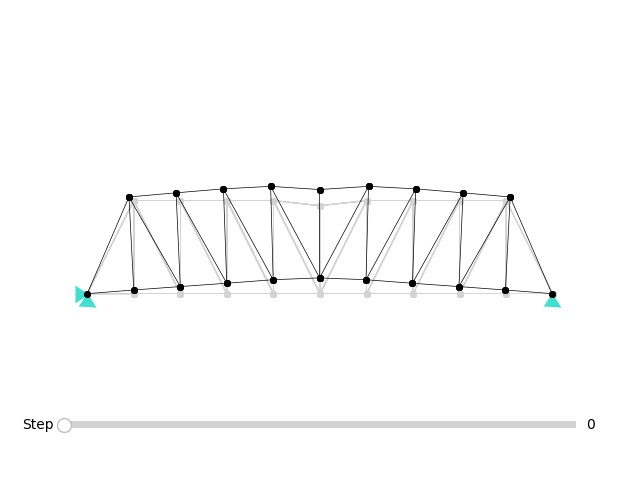

array([23.8621123 , 67.69421886, 85.50611602])

In [141]:
optimal_x = bopt.optimal_x
m, f = final_results(optimal_x)
print(m)
print(f)
print(optimal_x)
y = optimal_x[:5]
A = optimal_x[5:]
A = np.append([4e-3], A)
eigenfrequencies_1(A, y)

<Axes: >

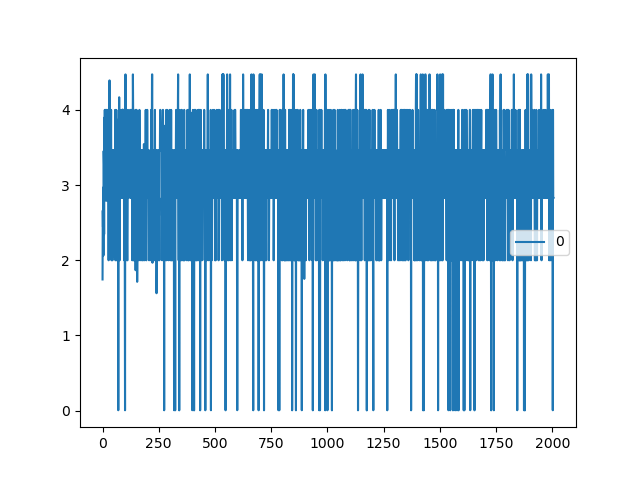

In [142]:
pd.DataFrame(bopt.distances_).plot()

<Axes: title={'center': 'Loss development'}, xlabel='Iterations', ylabel='Loss'>

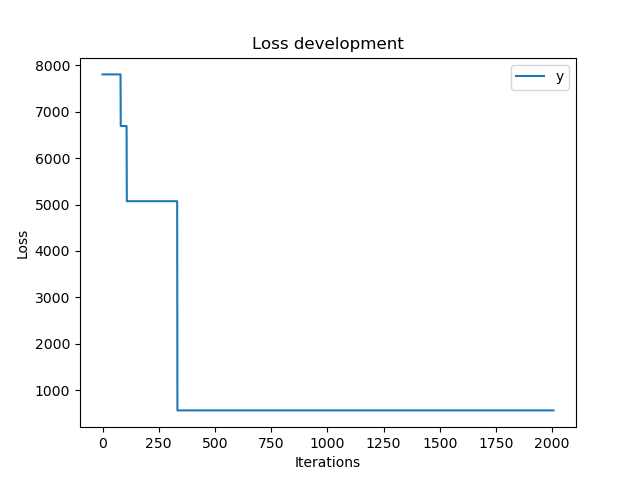

In [143]:
pd.DataFrame(bopt.best_samples_['y']).plot(title='Loss development', xlabel='Iterations', ylabel='Loss')

<Axes: >

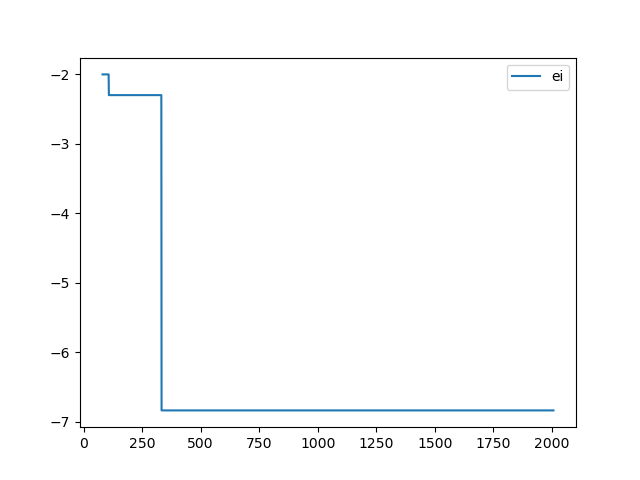

In [144]:
pd.DataFrame(bopt.best_samples_['ei']).plot()